In [10]:
# For data processing
import os
import lasio
import pandas as pd
from sys import stdout

# to plot
import matplotlib.pyplot as plt # to plot static 
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.gridspec as gridspec

# For DTW
from dtaidistance import dtw

In [11]:
os.chdir('/home/maria-fernanda/PhD/Spring_2025/Research/warmup/Datasets/combined_datasets/las_files')

In [12]:
# Function to get all the .las file names
def get_file_names():
    """Create list of well names from current directory"""
    file_names = []
    
    # Get list of directories in current working directory
    for item in os.listdir():
        file_names.append(item)
    file_names.sort()
    return file_names

file_names = get_file_names()

print("Found well names:", file_names)

Found well names: ['2HILOG.las', '3T-621_OH.las', 'CFU27-5.las', 'CFU29-12.las', 'CFU31F-1.las', 'CFU31F-2.las', 'CFU31F-3.las', 'CFU44-2.las', 'COP_Alaska_3T_621_Processed_RTScanner_RvRh.las', 'CPAI_Moraine_1_RTScanner_.las', 'Chevron2009Egypt.las', 'Kendrick 23-1.las', 'LLKING1-1.las', 'LUKEGU4-1.las', 'LUKEGU4-2.las', 'LUKEGU4-3.las', 'LUKEGU4-4.las', 'LUKEGU4-5.las', 'Longwood2.las', 'MLPScottA1.las', 'MORAINE_1_CORE_1_VSAND.las', 'MORAINE_1_CORE_2_VSAND.las', 'MORAINE_1_CORE_3_VSAND.las', 'MORAINE_1_CORE_PHI_K.las', 'MORAINE_1_CORE_SW.las', 'MORAINE_1_CORE_XRD_VCLAY.las', 'MORAINE_1_OH_DATA.las', 'MORAINE_1_RVRH.las', 'MontgomeryGU3HI.las', 'MontgomeryGU3HI2.las', 'NEWBY2-28R.las', 'PAULEPLUMMER1.las', 'Plot.png', 'SHANKLE2-9-1.las', 'shrimplingu2hi-1.las', 'shrimplingu2hi-2.las', 'warp.png']


In [13]:
# Function to store the las files in dictionary well_logs with key the well name.las

def las_read(file_names):
    """
    Reads multiple LAS files into a dictionary of DataFrames and renames the gamma ray curve to 'GR'.
    
    Args:
        file_names (list): List of LAS file paths
        
    Returns:
        dict: Dictionary mapping filenames to their respective DataFrames
    """
    well_logs = {}
    
    for file_name in file_names:
        try:
            # Check if file exists and is a valid LAS file
            if not os.path.isfile(file_name) or not file_name.endswith('.las'):
                print(f"Warning: {file_name} is not a valid LAS file")
                continue
                
            # Read the LAS file
            las_data = lasio.read(file_name)
            
            # Convert to DataFrame
            df = las_data.df()
            
            # Identify and rename the gamma ray curve
            for curve in las_data.curves:
                if 'gamma' in curve.mnemonic.lower() or 'gr' in curve.mnemonic.lower():
                    df.rename(columns={curve.mnemonic: 'GR'}, inplace=True)
                    break
            
            # Add metadata columns
            df['file_name'] = file_name
            df['curves'] = ', '.join(las_data.curves.keys())  # Store curve names as a single string
            
            # Add to well logs dictionary
            well_logs[file_name] = df
            
            print(f"Successfully processed {file_name}")
            
        except lasio.exceptions.LASHeaderError:
            print(f"Warning: {file_name} appears to be corrupted")
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
            
    return well_logs

# Example usage
#file_names = ['1044131941.las', '1001178532.las']
well_logs = las_read(file_names)

Successfully processed 2HILOG.las
Successfully processed 3T-621_OH.las


Only engine='normal' can read wrapped files


Successfully processed CFU27-5.las


Only engine='normal' can read wrapped files


Successfully processed CFU29-12.las


Only engine='normal' can read wrapped files


Successfully processed CFU31F-1.las


Only engine='normal' can read wrapped files
/tmp/ipykernel_461566/304591717.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['curves'] = ', '.join(las_data.curves.keys())  # Store curve names as a single string


Successfully processed CFU31F-2.las


Only engine='normal' can read wrapped files


Successfully processed CFU31F-3.las


Only engine='normal' can read wrapped files


Successfully processed CFU44-2.las
Successfully processed COP_Alaska_3T_621_Processed_RTScanner_RvRh.las
Successfully processed CPAI_Moraine_1_RTScanner_.las
Successfully processed Chevron2009Egypt.las
Successfully processed Kendrick 23-1.las
Successfully processed LLKING1-1.las
Successfully processed LUKEGU4-1.las
Successfully processed LUKEGU4-2.las
Successfully processed LUKEGU4-3.las
Successfully processed LUKEGU4-4.las
Successfully processed LUKEGU4-5.las
Successfully processed Longwood2.las


Only engine='normal' can read wrapped files


Successfully processed MLPScottA1.las
Successfully processed MORAINE_1_CORE_1_VSAND.las
Successfully processed MORAINE_1_CORE_2_VSAND.las
Successfully processed MORAINE_1_CORE_3_VSAND.las
Successfully processed MORAINE_1_CORE_PHI_K.las
Successfully processed MORAINE_1_CORE_SW.las
Successfully processed MORAINE_1_CORE_XRD_VCLAY.las
Successfully processed MORAINE_1_OH_DATA.las
Successfully processed MORAINE_1_RVRH.las
Successfully processed MontgomeryGU3HI.las
Successfully processed MontgomeryGU3HI2.las
Successfully processed NEWBY2-28R.las
Successfully processed PAULEPLUMMER1.las
Successfully processed SHANKLE2-9-1.las
Successfully processed shrimplingu2hi-1.las
Successfully processed shrimplingu2hi-2.las


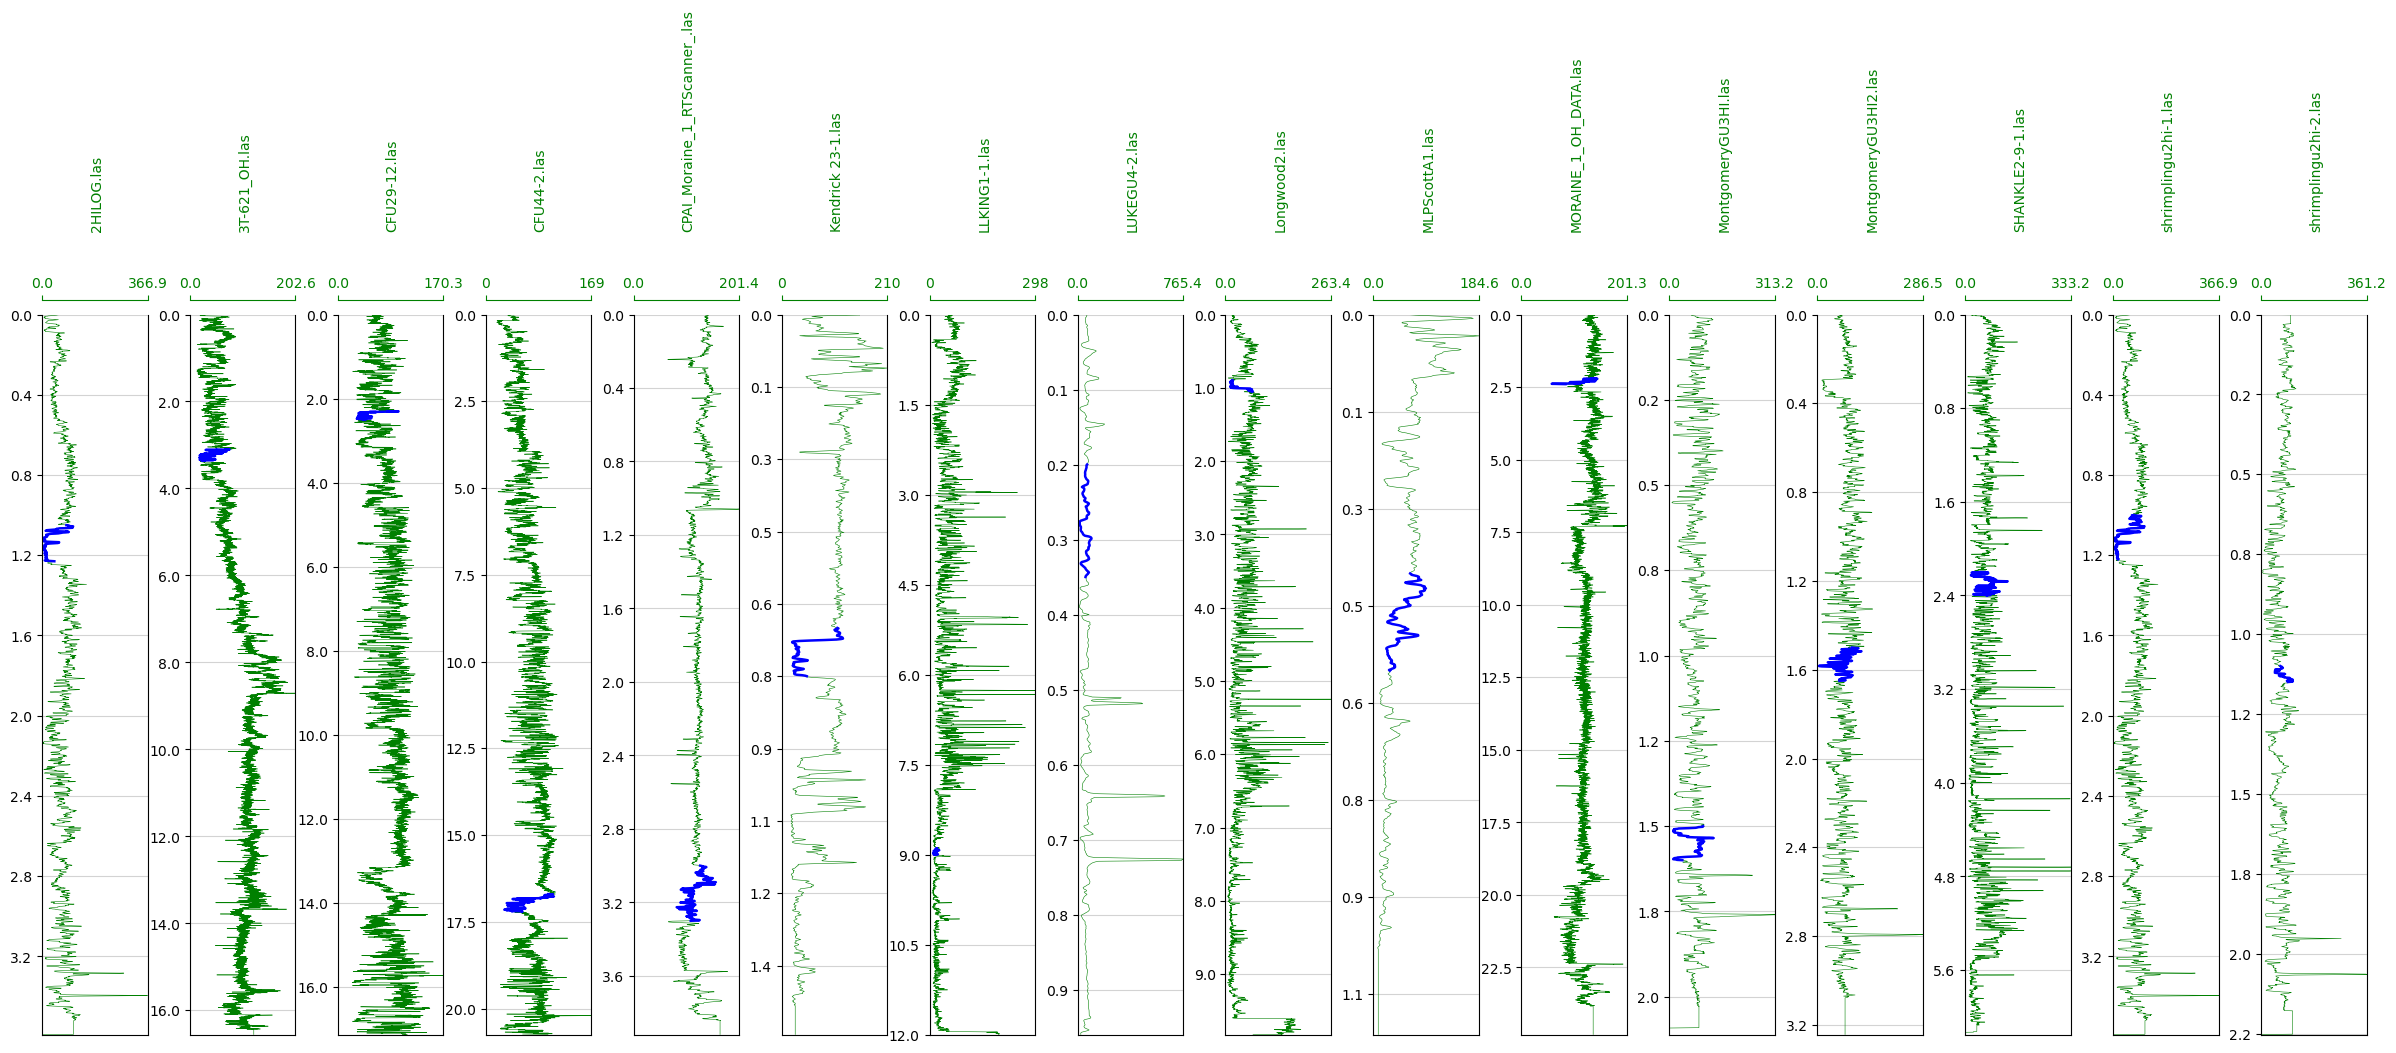

In [14]:
# Function to create stencils of different sizes for all wells gamma ray logs named GR, and return both the plot and the dictionaries of keys a tuble well name.las, size of stencil

stencil_sizes = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.75, 2.0, 2.5, 3.0]

def plot_GR(well_logs, p1_indices, window_sizes, sizes=stencil_sizes):
    """
    Plots the full 'GR' values of each DataFrame in a dictionary of DataFrames as subplots.
    Args:
        well_logs (dict): Dictionary where keys are well names and values are DataFrames
        p1_indices (list): List of starting indices for the stencil for each well
        window_sizes (list): List of stencil window sizes for each well
    """

    stencils = {}

    # Filter out DataFrames that do not have a 'GR' column or have invalid data
    valid_well_logs = {}
    for name, df in well_logs.items():
        if 'GR' in df.columns:
            # Check if 'GR' is a Series
            if isinstance(df['GR'], pd.Series):
                df['GR'] = pd.to_numeric(df['GR'], errors='coerce')
                df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['GR'])
                if not df.empty:
                    valid_well_logs[name] = df
            else:
                print(f"Warning: 'GR' column in {name} is not a Series.")
        else:
            print(f"Warning: 'GR' column missing in {name}.")

    num_wells = len(valid_well_logs)

    # Validation for window size
    if len(window_sizes) != num_wells:
        raise ValueError("The length of window_sizes must match the number of wells in well_logs.")
    
    if len(p1_indices) != num_wells:
        raise ValueError("The length of p1_indices must match the number of wells in well_logs.")
    
    # Create a gridspec with fixed width
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(1, num_wells, width_ratios=[1]*num_wells)
    
    for i, ((well_name, df), p1, window_size) in enumerate(zip(valid_well_logs.items(), p1_indices, window_sizes)):
        ax = fig.add_subplot(gs[i])
        df = df.reset_index(drop=True)
        ax.plot(df['GR'], df.index, color="green", linewidth=0.40)

        if p1 + window_size <= len(df):
            stencil = df['GR'].loc[p1:p1+window_size]
            ax.plot(stencil, stencil.index, color='blue', linewidth=1.80, label='Stencil')

            # Normalize depth of the stencil to shorten and lengthen and produce more stencils
            min_depth = stencil.index.min()
            max_depth = stencil.index.max()
            normalized_depth = (stencil.index - min_depth) / (max_depth - min_depth)
            
            # Create a list of sizes scale factors for stencils

            # Create rescaled stencils for each size
            for size in sizes:
                rescaled_index = normalized_depth * (max_depth - min_depth) * size + min_depth
                stencils[(well_name, size)] = pd.Series(stencil.values, index=rescaled_index)

        ax.set_xlabel(well_name, rotation=90)
        ax.xaxis.label.set_color("green")
        min_gr = 0
        max_gr = max(df['GR'])
        ax.set_xlim(min_gr, max_gr)
        ax.set_xticks([min_gr, max_gr])
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1000:.1f}'))
        ax.tick_params(axis='x', colors="green")
        ax.spines["top"].set_edgecolor("green")
        well_min_index = df.index.min()
        well_max_index = df.index.max()
        ax.set_ylim(well_min_index, well_max_index)
        ax.invert_yaxis()
        ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        ax.xaxis.set_label_coords(.52, 1.12)
        ax.tick_params(axis='y', which='both', left=True, labelleft=True)

    plt.subplots_adjust(left=0.1, right=1.65, top=0.95, bottom=0.05, wspace=0.4)
    plt.show()

    return fig, stencils

# Example usage
# well_logs = {f'Well{i+1}': pd.DataFrame({'GR': np.random.rand(10000)}) for i in range(16)}
p1_indices = [1050, 3100, 2300, 16700, 3000, 650, 8900, 200, 900, 400, 2200, 1500, 1500, 2200, 1000, 1100]
window_sizes = [180, 260, 200, 500, 300, 100, 100, 150, 150, 150, 200, 100, 150, 200, 220, 50]

fig, stencils_dict = plot_GR(well_logs, p1_indices, window_sizes)

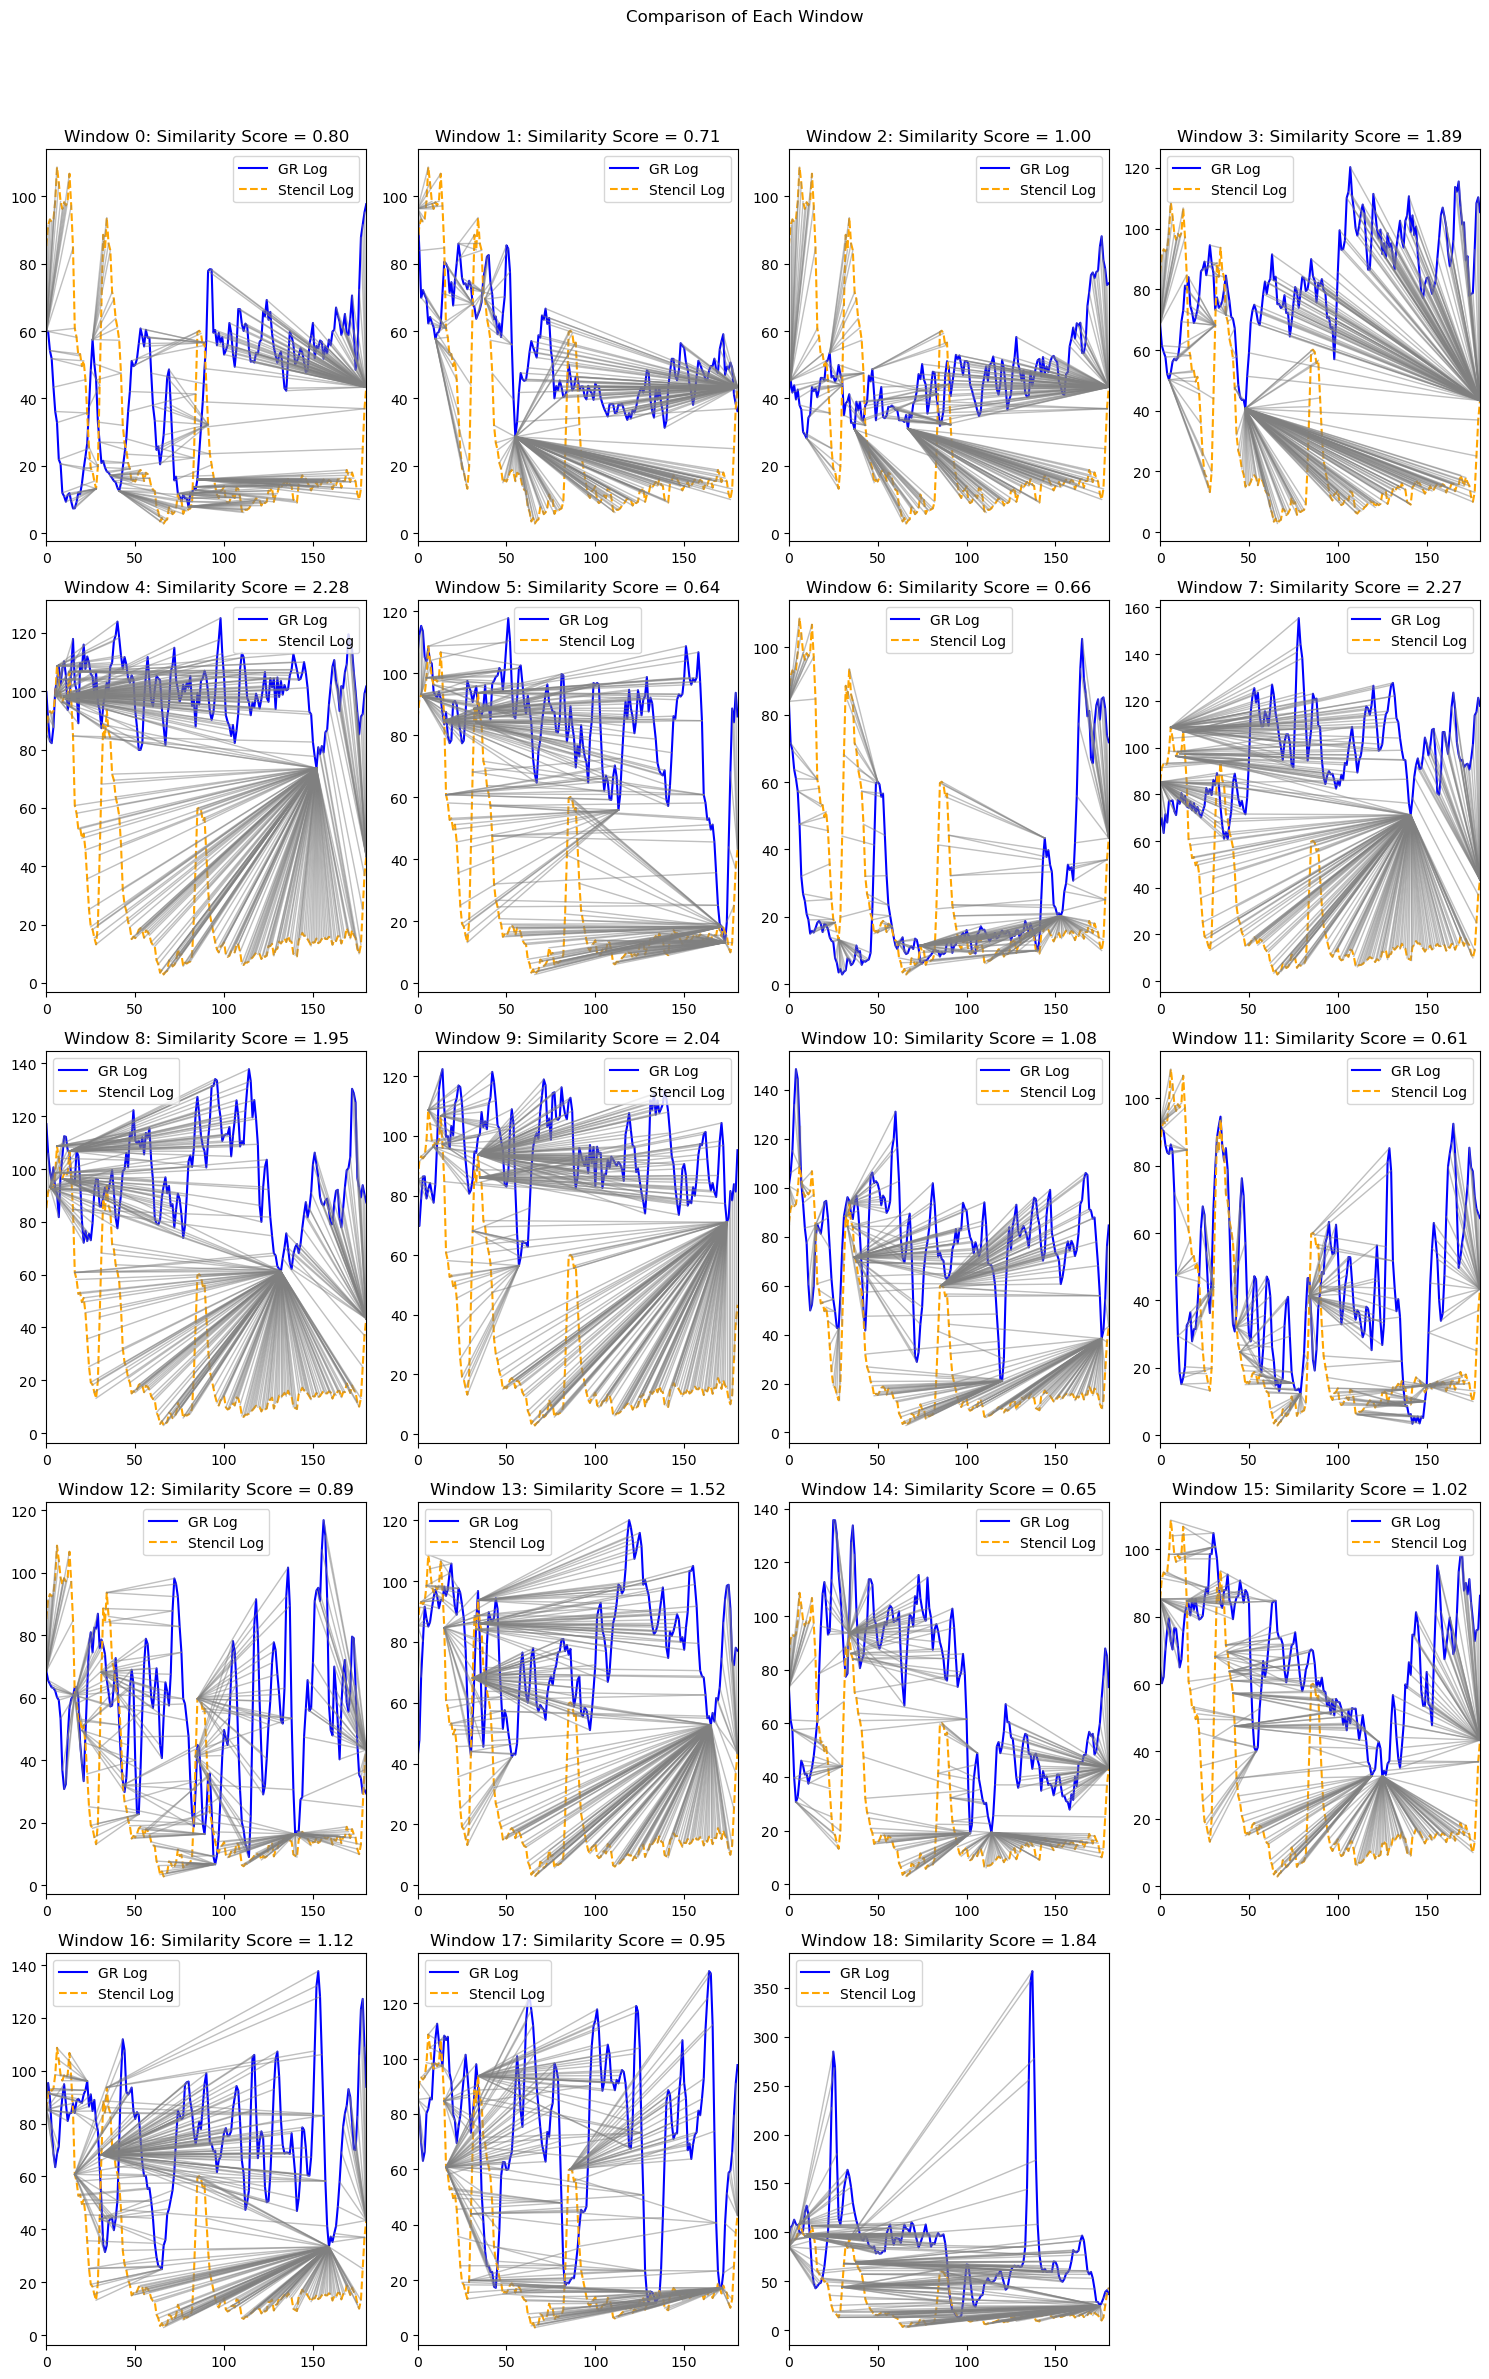

    Window ID  Similarity Score  Index Min  Index Max
0           0          0.798998          0        180
1           1          0.709523        181        361
2           2          0.998081        362        542
3           3          1.890490        543        723
4           4          2.278426        724        904
5           5          0.639959        905       1085
6           6          0.656374       1086       1266
7           7          2.265175       1267       1447
8           8          1.945250       1448       1628
9           9          2.041133       1629       1809
10         10          1.084755       1810       1990
11         11          0.606964       1991       2171
12         12          0.889474       2172       2352
13         13          1.520718       2353       2533
14         14          0.652841       2534       2714
15         15          1.016646       2715       2895
16         16          1.123802       2896       3076
17         17          0.953

In [15]:
# Function that calculates and plots the similarity metric from Dynamic Time Warping for different windows

def plot_dtw_similarity(well_logs, stencils_dict, well_name, size):
    """
    Plots the DTW similarity between a well log and a stencil for a given well and size.
    
    Args:
        well_logs (dict): Dictionary containing well log data.
        stencils_dict (dict): Dictionary containing stencil data.
        well_name (str): The name of the well to analyze.
        size (float): The size factor of the stencil to use.
    """
    # Sample data
    gr_data_full = well_logs[well_name]['GR']
    stencil_data = stencils_dict[(well_name, size)].values
    size_stencil = len(stencil_data)

    # Calculate the number of full windows
    no_windows = len(gr_data_full) // size_stencil

    # Determine the number of rows needed for 3 columns
    ncols = 4
    nrows = (no_windows + ncols - 1) // ncols  # Ceiling division to ensure enough rows

    # Create subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    fig.suptitle('Comparison of Each Window')

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Prepare a list to store results
    results = []

    # Iterate over non-overlapping windows
    for i in range(no_windows):
        start_index = i * size_stencil
        end_index = start_index + size_stencil
        window = gr_data_full.iloc[start_index:end_index].values

        # Calculate DTW distance and obtain the warping paths
        distance, paths = dtw.warping_paths(window, stencil_data, use_c=False)
        best_path = dtw.best_path(paths)
        similarity_score = distance / len(best_path)

        # Store the results
        results.append({
            'Window ID': i,
            'Similarity Score': similarity_score,
            'Index Min': start_index,
            'Index Max': end_index - 1
        })

        # Plot each window in a separate subplot
        axs[i].plot(window, label='GR Log', color='blue')
        axs[i].plot(stencil_data, label='Stencil Log', linestyle='--', color='orange')
        axs[i].set_title(f'Window {i}: Similarity Score = {similarity_score:.2f}')
        axs[i].legend()
        axs[i].set_xlim(0, size_stencil - 1)

        # Add point-to-point comparison lines
        for a, b in best_path:
            axs[i].plot([a, b], [window[a], stencil_data[b]], color='grey', linestyle='-', linewidth=1, alpha=0.5)

    # Hide any unused subplots
    for j in range(no_windows, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    print(results_df)

# Example usage
plot_dtw_similarity(well_logs, stencils_dict, '2HILOG.las', 0.25)